Setup and Imports 

In [1]:
import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])

0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")

Load All Features

In [3]:
features_path = Path("../data/processed/all_features.csv")

df = pd.read_csv(features_path)
df.head()

,hr,rmssd,sdnn,pnn50,eda_mean,eda_std,eda_slope,temp_mean,temp_slope,label,subject
0,140.0,4.414057,4.413311,0.942408,0.293610,0.001887,-0.000040,31.143333,0.000000,0,S10
1,140.0,4.132686,4.132314,0.968586,0.292944,0.002254,-0.000013,31.143333,0.000000,0,S10
2,140.0,3.396746,3.396744,0.973822,0.292198,0.001885,-0.000013,31.142604,-0.000104,0,S10
3,160.0,3.249087,3.248571,0.994764,0.291625,0.001771,0.000027,31.135938,-0.000104,0,S10
4,160.0,3.120645,3.120622,0.994764,0.291818,0.001350,-0.000007,31.130000,0.000000,0,S10


Clean for Baseline vs Stress

In [4]:
df = df[df["label"].isin([1,2])].copy()
df["label"] = df["label"].map({1:0, 2:1})
df.dropna(inplace=True)

print(df.shape)
df.head()

(30146, 11)


,hr,rmssd,sdnn,pnn50,eda_mean,eda_std,eda_slope,temp_mean,temp_slope,label,subject
101,200.0,3.036818,3.035877,0.989529,0.269160,0.001103,0.000000,31.095937,-0.000104,0,S10
102,200.0,2.960776,2.960297,0.979058,0.268947,0.001061,0.000000,31.089271,-0.000104,0,S10
103,200.0,2.949802,2.949759,0.984293,0.269007,0.001077,-0.000007,31.083333,0.000000,0,S10
104,200.0,3.040868,3.040801,0.984293,0.268640,0.001092,-0.000013,31.083333,0.000000,0,S10
105,200.0,3.009892,3.009720,0.984293,0.268627,0.001045,0.000000,31.083333,0.000000,0,S10


In [5]:
df["subject"].value_counts().sort_index()

subject
S10    2083
S11    2034
S13    2015
S14    2028
S15    2034
S16    2025
S17    2082
S2     1924
S3     1946
S4     1962
S5     2009
S6     2000
S7     1997
S8     2011
S9     1996
Name: count, dtype: int64

Class Balance and Feature Distributions

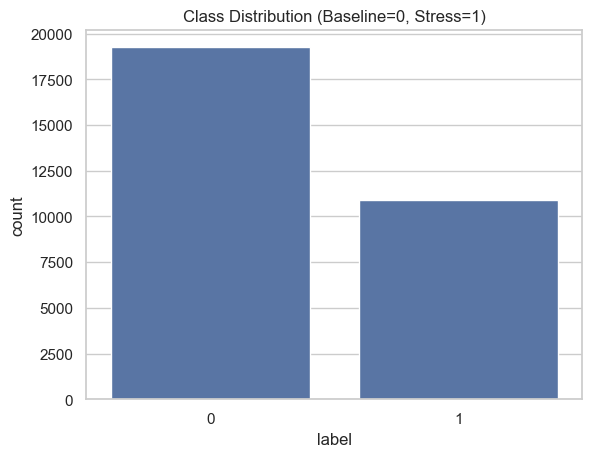

In [6]:
sns.countplot(data=df, x="label")
plt.title("Class Distribution (Baseline=0, Stress=1)")
plt.show()

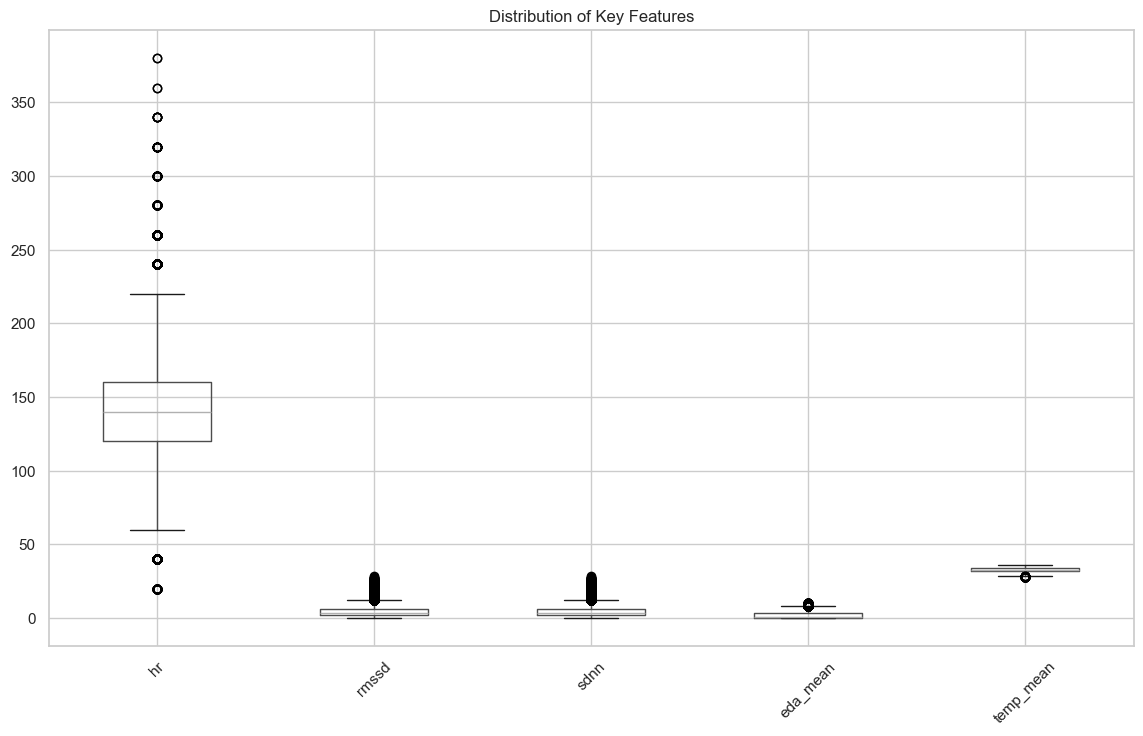

In [7]:
plt.figure(figsize=(14,8))
df.boxplot(column=["hr", "rmssd", "sdnn", "eda_mean", "temp_mean"])
plt.title("Distribution of Key Features")
plt.xticks(rotation=45)
plt.show()

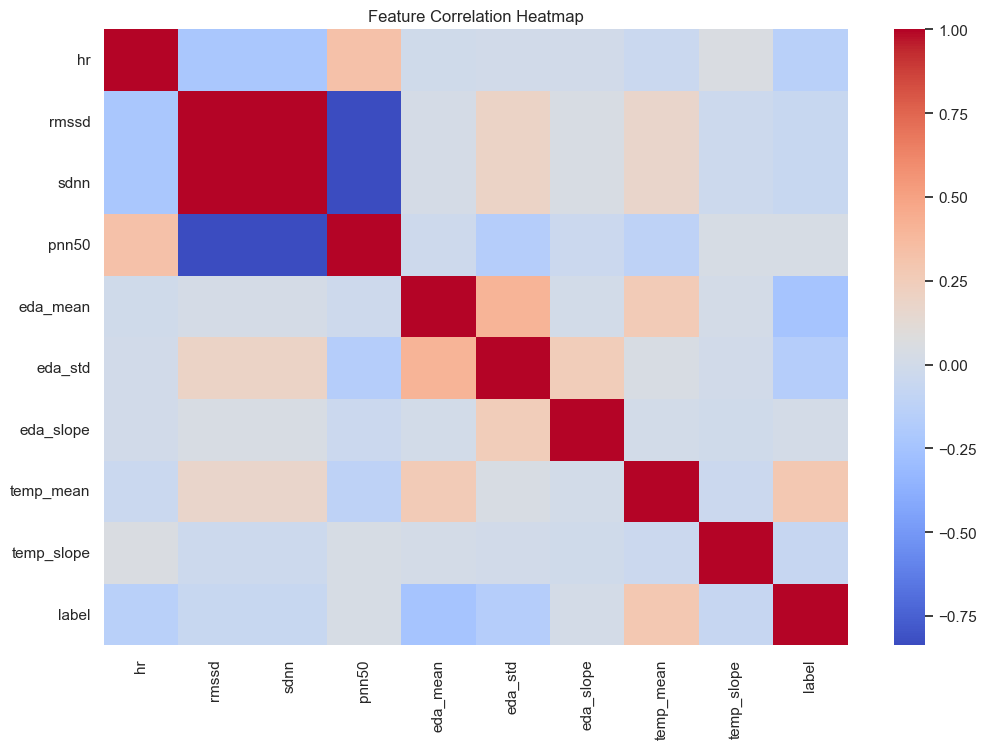

In [9]:
plt.figure(figsize=(12,8))

numeric_df = df.select_dtypes(include=["float64", "int64"])
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")

plt.title("Feature Correlation Heatmap")
plt.show()

LOSO Training Loop and Plotting

In [11]:
import pandas as pd
from pathlib import Path

loso_path = Path("../models/loso_results.csv")
loso = pd.read_csv(loso_path)
loso

,subject,accuracy,f1,auc
0,S2,0.349272,0.517720,0.219428
1,S3,0.738438,0.428732,0.924483
2,S4,0.752294,0.740938,0.963888
3,S5,0.568940,0.462779,0.564802
4,S6,0.860000,0.753954,0.997334
5,S7,0.736104,0.396334,0.888487
6,S8,0.815017,0.677083,0.885209
7,S9,0.653808,0.630679,0.801673
8,S10,0.715795,0.724138,0.896059
9,S11,0.943953,0.928839,0.959408


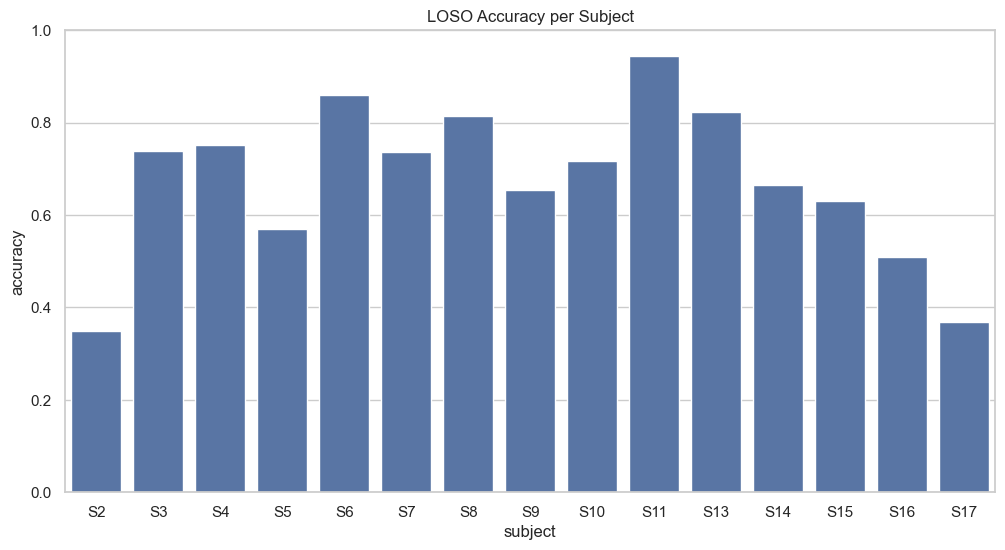

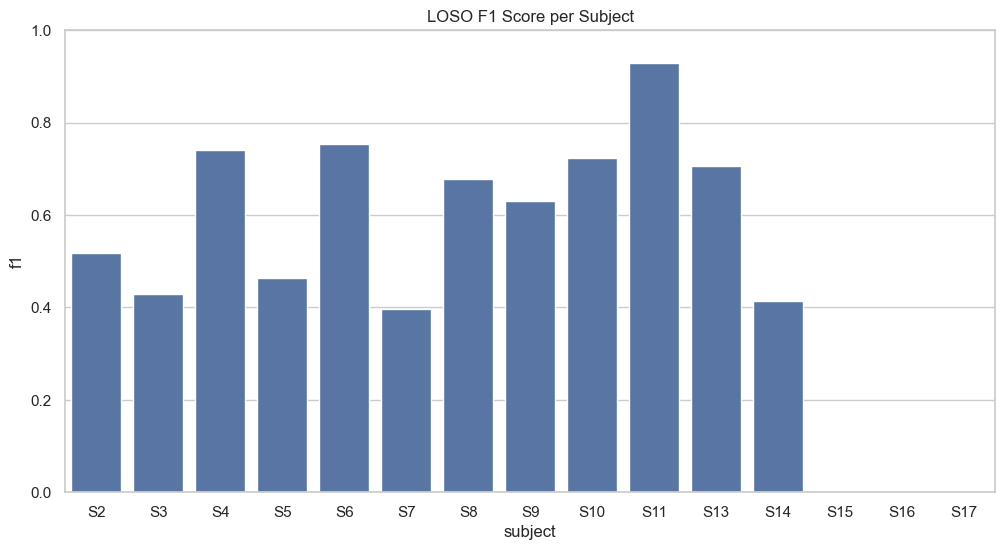

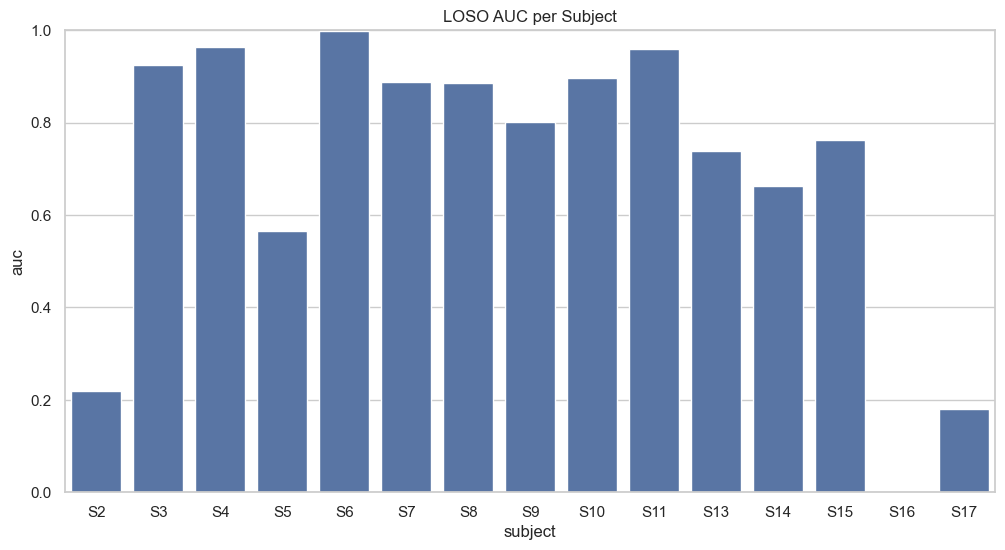

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(data=loso, x="subject", y="accuracy")
plt.ylim(0,1)
plt.title("LOSO Accuracy per Subject")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=loso, x="subject", y="f1")
plt.ylim(0,1)
plt.title("LOSO F1 Score per Subject")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=loso, x="subject", y="auc")
plt.ylim(0,1)
plt.title("LOSO AUC per Subject")
plt.show()


In [13]:
print("Mean Accuracy:", loso["accuracy"].mean())
print("Mean F1:", loso["f1"].mean())
print("Mean AUC:", loso["auc"].mean())

Mean Accuracy: 0.6753957104701996
Mean F1: 0.4921253902202647
Mean AUC: 0.6963132457007536


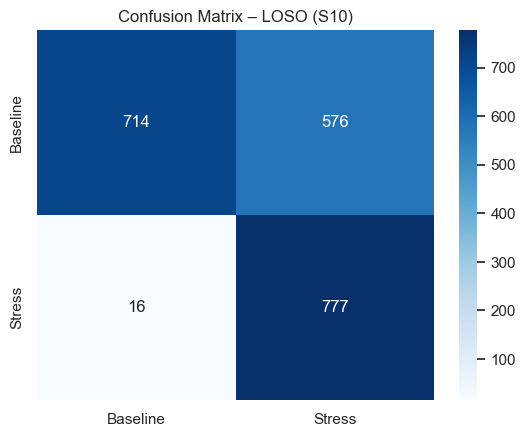

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

def confusion_for_subject(test_subj):
    # Split
    train = df[df["subject"] != test_subj]
    test  = df[df["subject"] == test_subj]

    X_train = train.drop(columns=["label", "subject"])
    y_train = train["label"]

    X_test = test.drop(columns=["label","subject"])
    y_test = test["label"]

    # Scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Model
    model = RandomForestClassifier(
        n_estimators=300, max_depth=12, random_state=42
    )
    model.fit(X_train_s, y_train)

    # Predictions
    pred = model.predict(X_test_s)

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Baseline", "Stress"],
                yticklabels=["Baseline", "Stress"])
    plt.title(f"Confusion Matrix – LOSO ({test_subj})")
    plt.show()

confusion_for_subject("S10")   # pick any subject


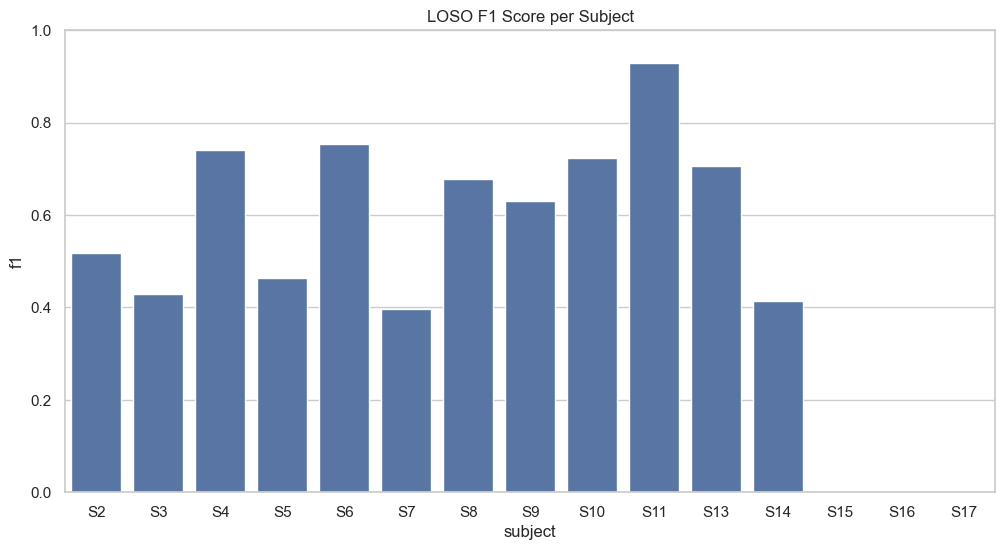

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(data=loso, x="subject", y="f1")
plt.ylim(0,1)
plt.title("LOSO F1 Score per Subject")
plt.savefig("../models/LOSO_F1.png", dpi=300)
plt.show()



Adding filtering

In [32]:
from scipy.signal import butter, filtfilt

def butter_filter(signal, low=None, high=None, fs=64, order=4):
    nyq = fs / 2
    
    if low and high:
        b, a = butter(order, [low/nyq, high/nyq], btype='band')
    elif high:
        b, a = butter(order, high/nyq, btype='low')
    elif low:
        b, a = butter(order, low/nyq, btype='high')
    else:
        return signal
    
    return filtfilt(b, a, signal)

In [33]:
bvp_df["filtered"] = butter_filter(bvp_df[0], low=0.5, high=4, fs=fs_bvp)

In [34]:
eda_df["filtered"] = butter_filter(eda_df[0], high=0.6, fs=fs_eda)

In [35]:
eda_df["filtered"] = butter_filter(eda_df[0], high=0.6, fs=fs_eda)

In [36]:
temp_df["filtered"] = butter_filter(temp_df[0], high=0.1, fs=fs_temp)

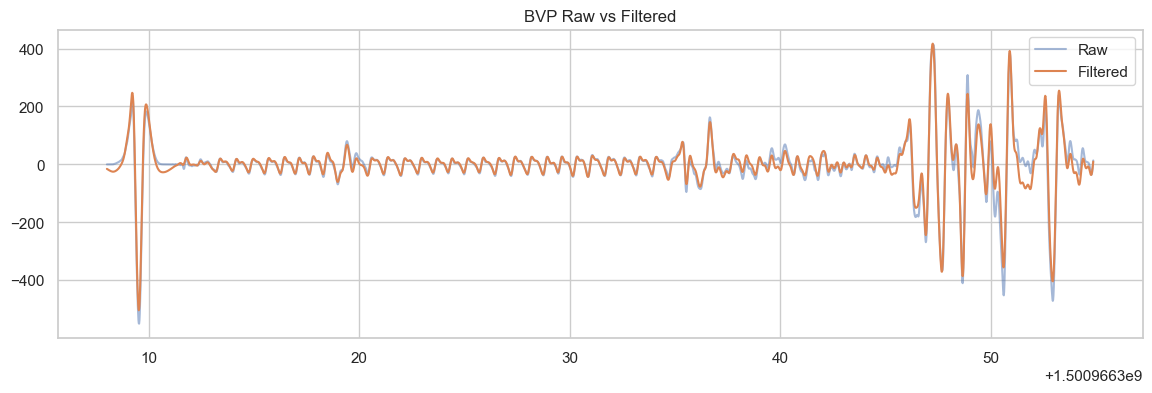

In [37]:
plt.figure(figsize=(14,4))
plt.plot(bvp_df["timestamp"].head(3000), bvp_df[0].head(3000), alpha=0.5, label="Raw")
plt.plot(bvp_df["timestamp"].head(3000), bvp_df["filtered"].head(3000), label="Filtered")
plt.title("BVP Raw vs Filtered")
plt.legend()
plt.show()

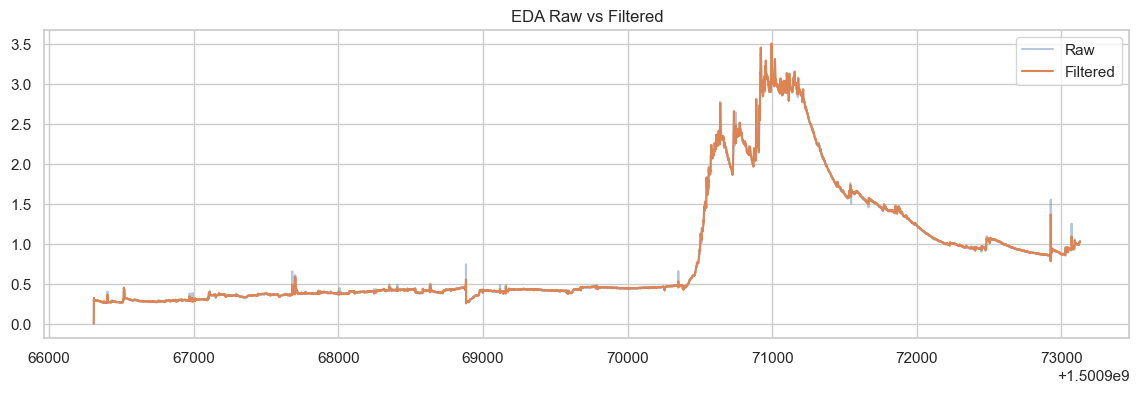

In [38]:
plt.figure(figsize=(14,4))
plt.plot(eda_df["timestamp"], eda_df[0], alpha=0.4, label="Raw")
plt.plot(eda_df["timestamp"], eda_df["filtered"], label="Filtered")
plt.title("EDA Raw vs Filtered")
plt.legend()
plt.show()

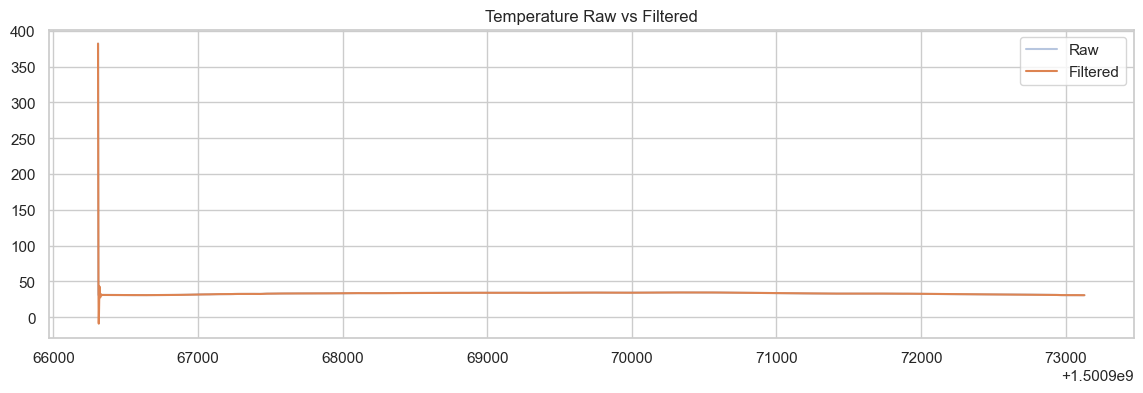

In [39]:
plt.figure(figsize=(14,4))
plt.plot(temp_df["timestamp"], temp_df[0], alpha=0.4, label="Raw")
plt.plot(temp_df["timestamp"], temp_df["filtered"], label="Filtered")
plt.title("Temperature Raw vs Filtered")
plt.legend()
plt.show()

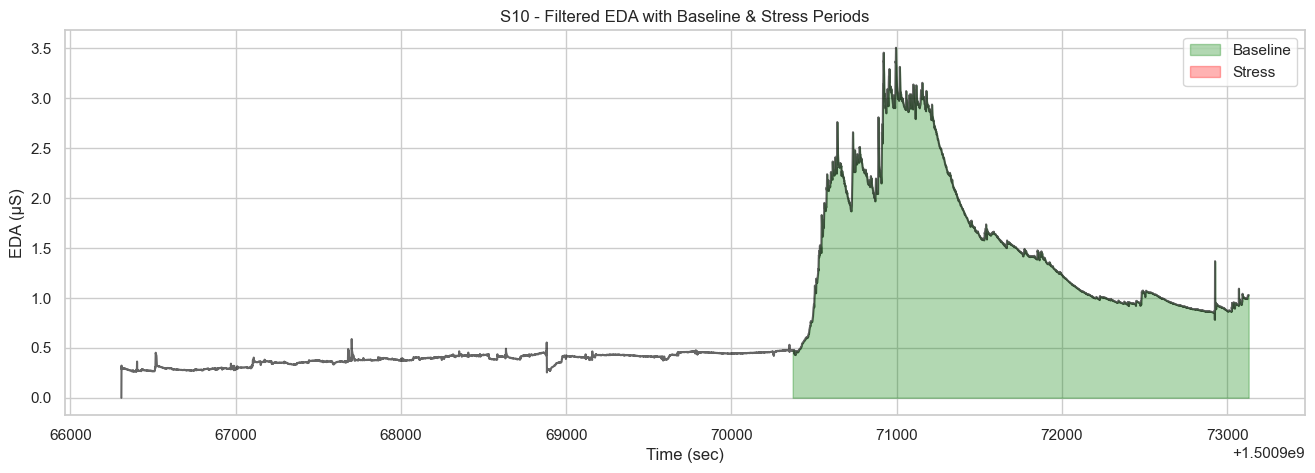

In [40]:
plt.figure(figsize=(16,5))
plt.plot(eda_vis["timestamp"], eda_df["filtered"].iloc[:len(eda_vis)], color="black", alpha=0.6)

plt.fill_between(eda_vis["timestamp"], 0, eda_df["filtered"].iloc[:len(eda_vis)],
                 where=baseline_mask, color="green", alpha=0.3, label="Baseline")

plt.fill_between(eda_vis["timestamp"], 0, eda_df["filtered"].iloc[:len(eda_vis)],
                 where=stress_mask, color="red", alpha=0.3, label="Stress")

plt.title(f"{subject} - Filtered EDA with Baseline & Stress Periods")
plt.xlabel("Time (sec)")
plt.ylabel("EDA (µS)")
plt.legend()
plt.show()

# Windowing Strategy
To convert continuous physiological signals into learnable units, we segmented the wrist signals (BVP, EDA, TEMP) into non-overlapping 5-second windows. This duration provides a balance between physiological validity and real-time applicability.

EDA responses typically take 4–8 seconds to rise during stress.

BVP and pulse-rate features stabilize over 5 seconds.

Temperature trends are slow, but slope changes are detectable in 5-second segments.

Shorter windows (1–2 seconds) were too noisy, while longer windows (30–60 seconds) significantly reduced the number of training samples and limit practical deployment.

# Feature Engineering & Physiological Signal Modeling

This section extracts and visualizes all engineered features, including:
- HRV-like features (HR, RMSSD, SDNN, pNN50)
- Advanced BVP features (Pulse Amplitude, Energy, PRV-SDNN)
- EDA features (SCR Count, SCR Amplitude, SCR Rise Rate)
- Temperature features (Slope, Variability, Derivative)

These features form the core of the ML model used for stress prediction.


In [44]:
import pandas as pd

df = pd.read_csv(r"C:\Stress Level Prediction from Physiological Signals\data\processed\all_features.csv")
df.head()

,hr,rmssd,sdnn,pnn50,eda_mean,eda_std,eda_slope,temp_mean,temp_slope,label,subject
0,140.0,4.414057,4.413311,0.942408,0.293610,0.001887,-0.000040,31.143333,0.000000,0,S10
1,140.0,4.132686,4.132314,0.968586,0.292944,0.002254,-0.000013,31.143333,0.000000,0,S10
2,140.0,3.396746,3.396744,0.973822,0.292198,0.001885,-0.000013,31.142604,-0.000104,0,S10
3,160.0,3.249087,3.248571,0.994764,0.291625,0.001771,0.000027,31.135938,-0.000104,0,S10
4,160.0,3.120645,3.120622,0.994764,0.291818,0.001350,-0.000007,31.130000,0.000000,0,S10


In [46]:
descriptions = [
    "Heart Rate from BVP peaks",
    "RMSSD (short-term variability)",
    "SDNN (overall variability)",
    "pNN50 (percentage >50ms diffs)",
    "Mean EDA",
    "Std Dev EDA",
    "EDA slope (trend)",
    "Mean Temperature",
    "Temperature slope",
    "BVP peak-to-peak amplitude",
    "BVP signal energy",
    "Pulse rate variability SDNN",
    "SCR count",
    "SCR mean amplitude",
    "SCR rise rate",
    "Temperature variability",
    "Temperature derivative",
    "Ground truth label"
]

df_summary = pd.DataFrame({
    "Feature": df.columns,
    "Description": descriptions[:len(df.columns)]
})

df_summary


,Feature,Description
0,hr,Heart Rate from BVP peaks
1,rmssd,RMSSD (short-term variability)
2,sdnn,SDNN (overall variability)
3,pnn50,pNN50 (percentage >50ms diffs)
4,eda_mean,Mean EDA
5,eda_std,Std Dev EDA
6,eda_slope,EDA slope (trend)
7,temp_mean,Mean Temperature
8,temp_slope,Temperature slope
9,label,BVP peak-to-peak amplitude


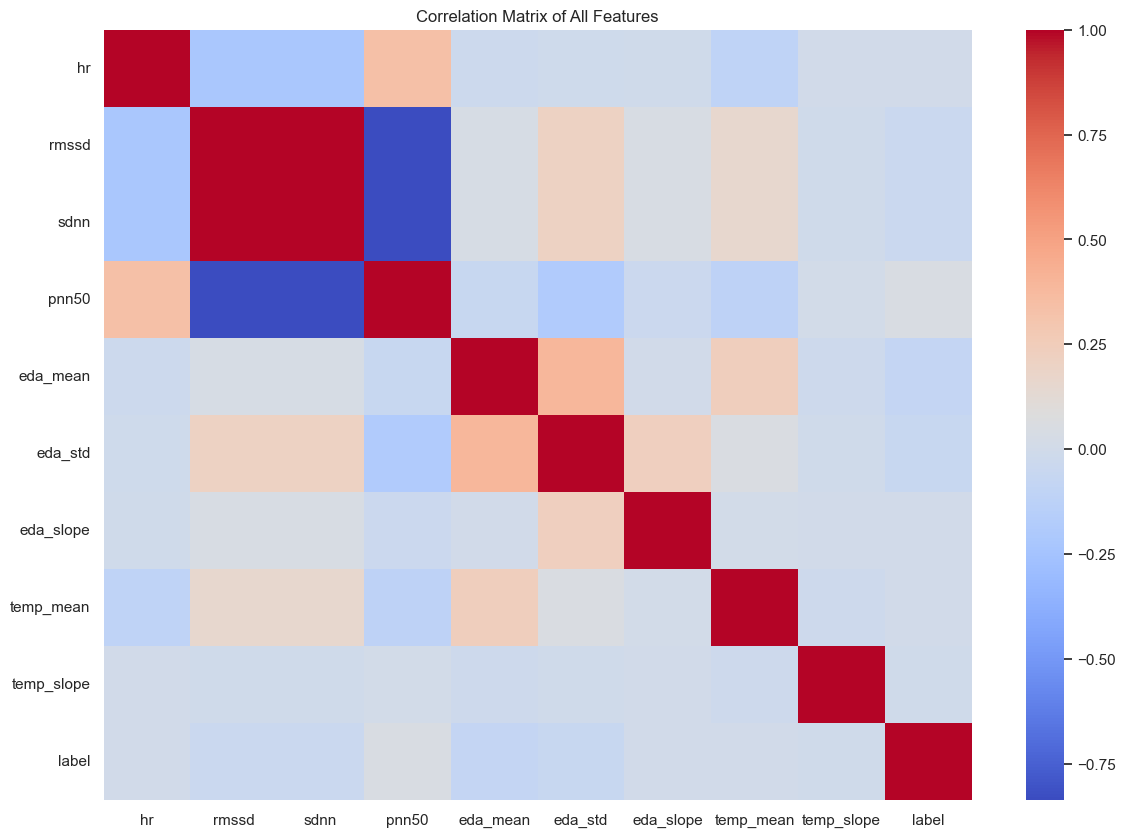

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
corr = df.drop(columns=["subject"], errors="ignore").corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of All Features")
plt.show()

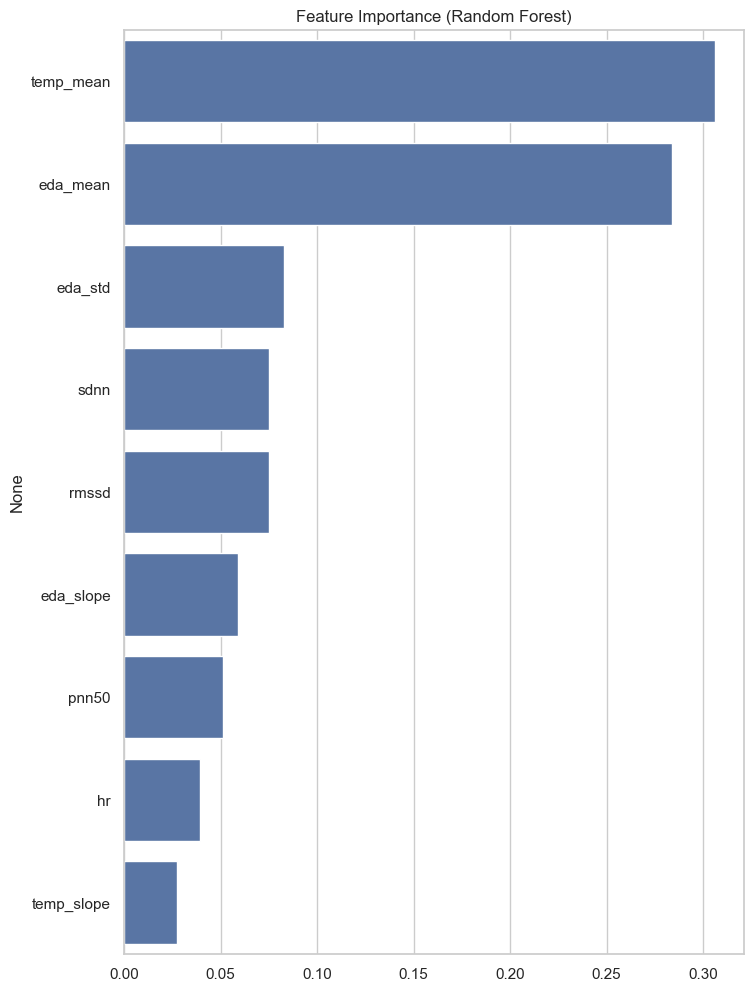

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X = df.drop(columns=["label", "subject"], errors="ignore")
y = df["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_scaled, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,12))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importance (Random Forest)")
plt.show()

## Feature Architecture Diagram


                ┌───────────────────────────────────────┐
                │      WEARABLE PHYSIOLOGICAL DATA       │
                └───────────────────────────────────────┘
                               │
                               ▼
     ┌────────────────────────────────────────────────────────────┐
     │                    RAW SENSOR STREAMS                      │
     └────────────────────────────────────────────────────────────┘
               │                 │                  │
               ▼                 ▼                  ▼
        ┌────────────┐    ┌────────────┐    ┌──────────────┐
        │    BVP     │    │    EDA     │    │   TEMP       │
        │  (64 Hz)   │    │   (4 Hz)   │    │   (4 Hz)     │
        └────────────┘    └────────────┘    └──────────────┘
               │                 │                  │
               ▼                 ▼                  ▼
    ┌────────────────┐  ┌────────────────┐  ┌────────────────┐
    │  Preprocessing │  │  Preprocessing │  │  Preprocessing │
    │  - Bandpass    │  │  - Low-pass    │  │  - Low-pass    │
    │  - Normalize   │  │  - Smooth      │  │  - Normalize   │
    └────────────────┘  └────────────────┘  └────────────────┘
               │                 │                  │
               ▼                 ▼                  ▼
    ┌────────────────┐  ┌────────────────┐  ┌────────────────┐
    │   BVP Features │  │   EDA Features │  │  Temp Features │
    └────────────────┘  └────────────────┘  └────────────────┘
               │                 │                  │
               ▼                 ▼                  ▼

    ┌────────────────────────────────────────────────────────────┐
    │                   FINAL FEATURE SET (ML)                    │
    └────────────────────────────────────────────────────────────┘

RAW vs FILTERED SIGNAL Plotting Cell

In [51]:
raw = pd.read_csv(r"C:\Stress Level Prediction from Physiological Signals\data\interim\S10_clean.csv")
raw.head()

,bvp,timestamp,eda,temp
0,10.53,1.500966e+09,0.29421,31.15
1,10.88,1.500966e+09,0.29421,31.15
2,10.75,1.500966e+09,0.29421,31.15
3,9.92,1.500966e+09,0.29421,31.15
4,8.28,1.500966e+09,0.29421,31.15


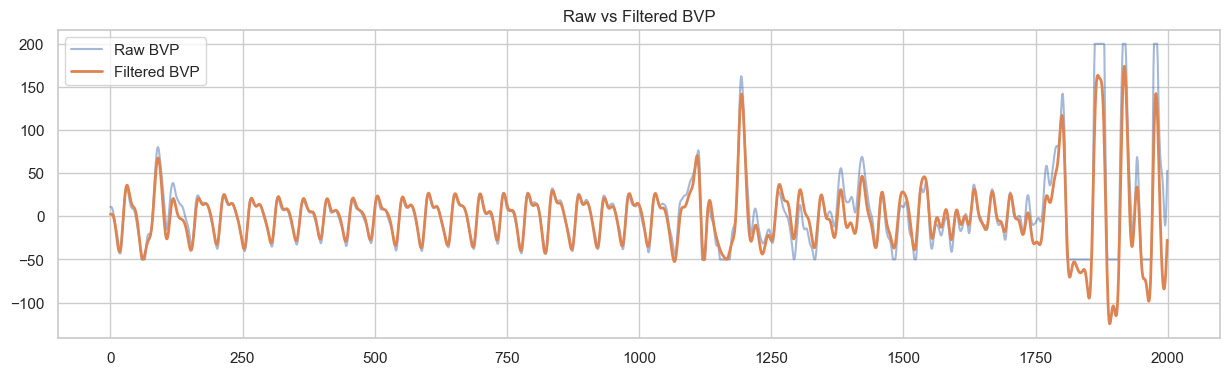

In [53]:
sample_bvp = raw["bvp"].values[:2000]   # raw signal!
filtered_bvp = butter_filter(sample_bvp, 0.5, 4, 64)

plt.figure(figsize=(15,4))
plt.plot(sample_bvp, alpha=0.5, label="Raw BVP")
plt.plot(filtered_bvp, linewidth=2, label="Filtered BVP")
plt.legend()
plt.title("Raw vs Filtered BVP")
plt.show()